# Does Geographical Location Affect Cabernet Sauvignon Wine Ratings?

# Introduction

Grown in nearly every major wine producing country, Cabernet Sauvignon is one of the world’s most widely recognized red wine grape varieties (Muñoz, Flavio, et al., 2021). From Australia’s Hunter Valley to Canada’s British Columbia to Lebanon’s Beqaa Valley, these diverse climates accentuate different flavour profiles of the Cabernet Sauvignon grape in wine.

For example, in cooler climates, Cabernet Sauvignon wines have blackcurrant notes that can be accompanied by green bell pepper notes, mint and cedar which will all become more pronounced as the wine ages. While in more moderate climates, the black currant notes are often seen with black cherry and black olive notes; and in very hot climates, the currant flavors can veer towards the over-ripe and "jammy" side.

Therefore, we can see that location plays an important role in a wine’s quality. Better known by the French word, terroir is composed of three characteristics, soil, climate, and cultivar, which dictate wine quality (Lock, Peter, et al., 2019). These characteristics yield a multitude of chemical and sensory personalities; and, more notably, can significantly affect the quality of Cabernet Sauvignon wines (Muñoz, Flavio, et al., 2021).

Understanding a grape’s personality is fundamental, and knowing if the geographical location in which grapes are grown can affect sommeliers’ blind tasting is one of the essences of appreciating wine. We would like to explore how the appellations determine which grapes excel in wine ratings. This leads to the question: how does growing Cabernet Sauvignon grapes in Napa Valley and Columbia Valley affect its wine ratings? We’ll focus on the data scraped from WineEnthusiast during the week of June 15th, 2017 to study the influence of these two regions towards wine ratings. Additionally, we will be examining and comparing at the mean ratings and their standard deviations for each region to determine the average rating and its variability. **(EXPLAIN WHY WE CHOSE THESE SCALE PARAMETERS).*** 


# Preliminary Results

We first load the downloaded data set from Kaggle's open data set. Then, we filter to see only wines made from the Cabernet Sauvignon grape, and select the columns relevant to our study: the region the grape was grown in and the rating/points the wine received on a scale of 0-100.

In [1]:
library(tidyverse)
library(dplyr)
library(digest)
library(infer)
library(repr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘infer’ was built under R version 4.0.2”


In [2]:
cs_wine <- read_csv("winemag-data_first150k.csv") %>%
        filter(variety == "Cabernet Sauvignon") %>%
        select(points, region_1) 

"Table 1: The Data Set"
head(cs_wine)

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  X1 = col_double(),
  country = col_character(),
  description = col_character(),
  designation = col_character(),
  points = col_double(),
  price = col_double(),
  province = col_character(),
  region_1 = col_character(),
  region_2 = col_character(),
  variety = col_character(),
  winery = col_character()
)



[1] "Table 1: The Data Set"

points,region_1
<dbl>,<chr>
96,Napa Valley
95,Diamond Mountain District
90,Mount Veeder
90,Red Mountain
90,Red Mountain
91,Napa Valley


In [3]:
sampling_dist <- cs_wine %>%
                group_by(region_1) %>%
                summarize(sample_mean = mean(points))

"Table 2: Sample Means for Each Region"
head(sampling_dist)

`summarise()` ungrouping output (override with `.groups` argument)



[1] "Table 2: Sample Means for Each Region"

region_1,sample_mean
<chr>,<dbl>
Adelaida District,96.00000
Adelaide Hills,88.80000
Adelaide Plains,85.00000
Agrelo,85.91667
Alexander Valley,88.31697
Alghero,90.00000


# ASK

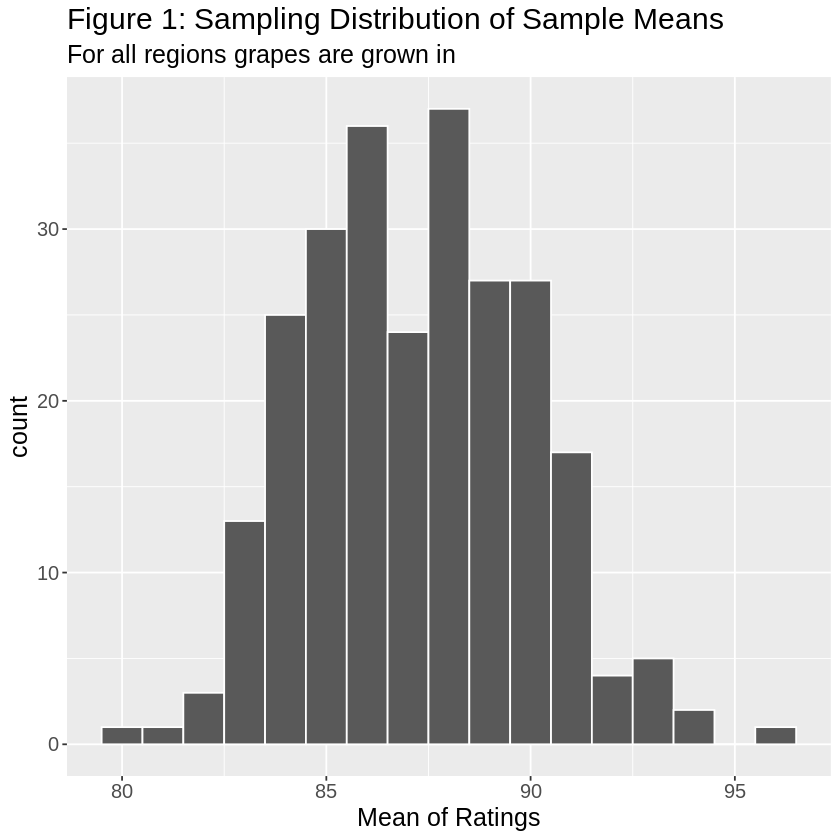

In [10]:
sampling_dist_plot <- sampling_dist %>%
                    ggplot() +
                    geom_histogram(aes(x = sample_mean), binwidth = 1, colour = "white") +
                    labs(title = "Figure 1: Sampling Distribution of Sample Means", 
                         subtitle = "For all regions grapes are grown in",
                         x = "Mean of Ratings") +
                    theme(text = element_text(size = 15))
sampling_dist_plot

In [5]:
locations <- cs_wine %>%
                group_by(region_1) %>%
                tally(sort = TRUE)

"Table 3: Number of Grapes Grown in Each Region"
head(locations)

[1] "Table 3: Number of Grapes Grown in Each Region"

region_1,n
<chr>,<int>
Napa Valley,2513
NA,1743
Columbia Valley (WA),766
Mendoza,560
Alexander Valley,489
Paso Robles,474


From Table 3, we can see that the top 2 regions in which Cabernet Sauvignon grapes are grown in are Napa Valley and Columbia Valley. The following table will display the mean and standard deviation of each region's ratings, and the figures will display the distribution of ratings. 

Note that we will disregard NA because the data set has missing values.

In [6]:
summary <- cs_wine %>%
            filter(region_1 == "Napa Valley" | region_1 == "Columbia Valley (WA)") %>%
            group_by(region_1) %>%
            summarize(sample_mean = mean(points),
                      sd = sd(points),
                      n = n())

"Table 4: Napa Valley and Columbia Valley Sample Mean and Standard Deviation"
summary

`summarise()` ungrouping output (override with `.groups` argument)



[1] "Table 4: Napa Valley and Columbia Valley Sample Mean and Standard Deviation"

region_1,sample_mean,sd,n
<chr>,<dbl>,<dbl>,<int>
Columbia Valley (WA),89.22585,3.116041,766
Napa Valley,89.26661,3.486974,2513


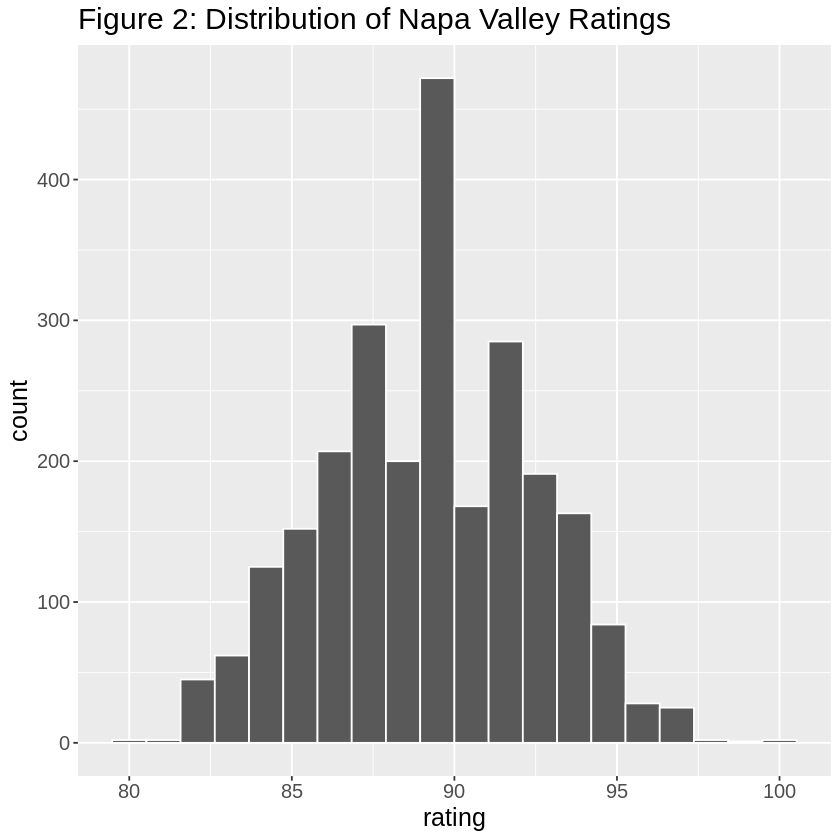

In [11]:
nv_plot <- cs_wine %>%
        filter(region_1 == "Napa Valley") %>%
        ggplot() +
        geom_histogram(aes(x = points), colour = "white", bins = 20) +
        labs(title = "Figure 2: Distribution of Napa Valley Ratings",
             x = "rating") +
        theme(text = element_text(size = 15))
nv_plot

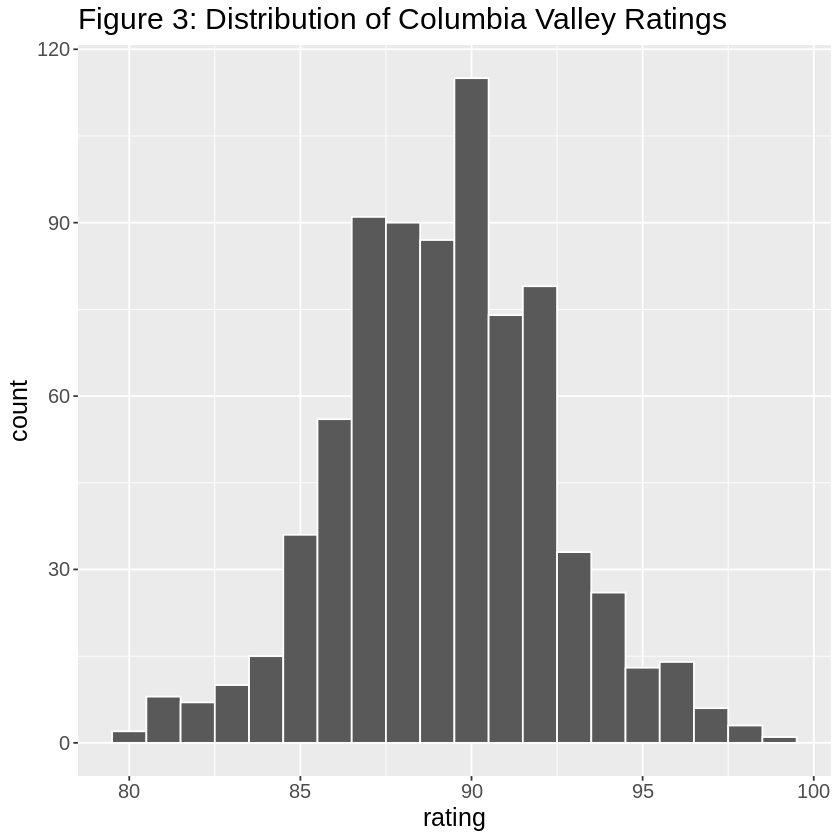

In [12]:
cv_plot <- cs_wine %>%
        filter(region_1 == "Columbia Valley (WA)") %>%
        ggplot() +
        geom_histogram(aes(x = points), colour = "white", bins = 20) +
        labs(title = "Figure 3: Distribution of Columbia Valley Ratings",
             x = "rating") +
        theme(text = element_text(size = 15))
cv_plot

# Methods: Plan

This report takes advantage of the large data set we're using; and it remains large after filtering it to focus on one specific grape. The large sample size helps us know that there is enough data so that results are less likely to be biased towards one direction, and the large sample size helps with creating a narrower confidence interval, which we will later construct. 

Although the estimates in Table 4 and Figures 2 and 3 provide a numerical and pictorial understanding of the mean and standard deviation of each region, it is not enough to see whether or not the region affects the rating as they merely describe the spread of the data. 

To bridge the gap, we will conduct a hypothesis test to determine whether or not Cabernet Sauvignon grapes grown in the 2 regions, Napa Valley and Columbia Valley, affect the wine ratings. Namely, our null hypothesis will be $H_0 = \mu_1 = \mu_2$, where $\mu_1$ is the mean of the points of the grape grown in Napa Valley and $\mu_2$ is that of Columbia Valley. And our alternative hypothesis is $H_1 = \mu_1 \neq \mu_2$. Additionally, we will be calculating 90% confidence intervals to compare our bootstrapped and CLT distributions. 

We expect to find out whether or not growing Cabernet Sauvignon grapes in different regions will affect its wine ratings; and if it does affect the rating, how much it affects it.

The impacts of the findings could allow companies to make decisions on where to grow their grapes for wine, as well as allowing consumers to better understand how growing location affects the flavour profile of wines.

Future questions could include looking into how wineries can increase their profit by adjusting their crops to fit and cater to the demand. 

# References

Muñoz, Flavio, et al. “Phenolic Characterization of Cabernet Sauvignon Wines From Different Geographical   Indications of Mendoza, Argentina: Effects of Plant Material and Environment.” Frontiers in Sustainable Food Systems, vol. 5, 2021, doi:10.3389/fsufs.2021.700642. Accessed 1 Aug. 2021.

Lock, Peter, et al., Wineries and wine quality: The influence of location and archetype in the Hunter Valley region in Australia, Wine Economics and Policy, vol. 8, issue 2, 2019, 180-190, doi.org/10.1016/j.wep.2019.10.002. Accessed 1 Aug. 2021.
     
https://www.kaggle.com/zynicide/wine-reviews